<a href="https://colab.research.google.com/github/maneshnambiar/ai-pneumonia-detection/blob/master/AIML_7B_RSNA_Pneumonia_Detection_U_Net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:

import os
import random
import csv
import pydicom
import numpy as np
from skimage.transform import resize

Import of All the Libraries necessary 

Load Table,tag pneumonia label to dictionary

In [0]:
# empty dictionary
pneumonia_locations = {}
# load table
with open(os.path.join('../input/rsna-pneumonia-detection-challenge/stage_2_train_labels.csv'), mode='r') as infile:
    # open reader
    reader = csv.reader(infile)
    # skip header
    next(reader, None)
    # loop through rows
    for rows in reader:
        # retrieve information
        filename = rows[0]
        location = rows[1:5]
        pneumonia = rows[5]
        # if row contains pneumonia add label to dictionary
        # which contains a list of pneumonia locations per filename
        if pneumonia == '1':
            # convert string to float to int
            location = [int(float(i)) for i in location]
            # save pneumonia location in dictionary
            if filename in pneumonia_locations:
                pneumonia_locations[filename].append(location)
            else:
                pneumonia_locations[filename] = [location]

Import Keras, and layers

In [0]:
import keras
import tensorflow as tf
from keras.models import Model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


****Fucntion for
1. 1.Load Dicom file as numpy array
1. 2.create empty mask
1. 3.parse files one by one
1. 4.Return image and mask

In [0]:
class generator_single_channel(keras.utils.Sequence):
    
    def __init__(self, folder, filenames, pneumonia_locations=None, batch_size=32,
                 image_size=256, shuffle=True, predict=False):
        self.folder = folder
        self.filenames = filenames
        self.pneumonia_locations = pneumonia_locations
        self.batch_size = batch_size
        self.image_size = image_size
        self.shuffle = shuffle
        self.predict = predict
        self.on_epoch_end()
        
    def __load__(self, filename):
        # load dicom file as numpy array
        img = pydicom.dcmread(os.path.join(self.folder, filename)).pixel_array
        # create empty mask
        msk = np.zeros(img.shape)
        # get filename without extension
        filename = filename.split('.')[0]
        # if image contains pneumonia
        is_pneumonia = int(0)
        if filename in self.pneumonia_locations:
            # loop through pneumonia
            is_pneumonia = int(1)
            for location in self.pneumonia_locations[filename]:
                # add 1's at the location of the pneumonia
                x, y, w, h = location
                msk[y:y+h, x:x+w] = 1
        # resize both image and mask
        img = resize(img, (self.image_size, self.image_size), mode='reflect')
        msk = resize(msk, (self.image_size, self.image_size), mode='reflect')
        # if augment then horizontal flip half the time
        # if self.augment and random.random() > 0.5:
        #     img = np.fliplr(img)
        #     msk = np.fliplr(msk)

        # add trailing channel dimension
        img = np.expand_dims(img, axis=-1)
        msk = np.expand_dims(msk, axis=-1)
        is_pneumonia = np.array(is_pneumonia)

        return img, msk
    
    def __loadpredict__(self, filename):
        # load dicom file as numpy array
        img = pydicom.dcmread(os.path.join(self.folder, filename)).pixel_array
        # resize image
        img = resize(img, (self.image_size, self.image_size), mode='reflect')
        # add trailing channel dimension
        img = np.expand_dims(img, axis=-1)
        
        return img
        
    def __getitem__(self, index):
        # select batch
        filenames = self.filenames[index*self.batch_size:(index+1)*self.batch_size]
        # predict mode: return images and filenames
        if self.predict:
            # load files
            imgs = [self.__loadpredict__(filename) for filename in filenames]
            # create numpy batch
            imgs = np.array(imgs)
            
            return imgs,filenames
        # train mode: return images and masks
        else:
            # load files
            items = [self.__load__(filename) for filename in filenames]
            # unzip images and masks
            imgs, msks = zip(*items)
            # create numpy batch
            imgs = np.array(imgs)
            msks = np.array(msks)

            return imgs,msks
        
    def on_epoch_end(self):
        if self.shuffle:
            random.shuffle(self.filenames)
        
    def __len__(self):
        if self.predict:
            # return everything
            return int(np.ceil(len(self.filenames) / self.batch_size))
        else:
            # return full batches only
            return int(len(self.filenames) / self.batch_size)

**Finetuning**
**Model defn**

In [0]:
def conv2d_block(input_tensor, n_filters, kernel_size=3, batchnorm=True):
    # first layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    # second layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(x)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

**U net is the model of choice**

In [0]:
def get_unet(input_img, n_filters=16, dropout=0.5, batchnorm=True):
    # contracting path
    c1 = conv2d_block(input_img, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    p1 = MaxPooling2D((2, 2)) (c1)
    p1 = Dropout(dropout*0.5)(p1)

    c2 = conv2d_block(p1, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)
    p2 = MaxPooling2D((2, 2)) (c2)
    p2 = Dropout(dropout)(p2)

    c3 = conv2d_block(p2, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)
    p3 = MaxPooling2D((2, 2)) (c3)
    p3 = Dropout(dropout)(p3)

    c4 = conv2d_block(p3, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters=n_filters*16, kernel_size=3, batchnorm=batchnorm)
    
    # expansive path
    u6 = Conv2DTranspose(n_filters*8, (3, 3), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)

    u7 = Conv2DTranspose(n_filters*4, (3, 3), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)

    u8 = Conv2DTranspose(n_filters*2, (3, 3), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)

    u9 = Conv2DTranspose(n_filters*1, (3, 3), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [0]:
input_img = Input((224, 224, 1), name='img')
model = get_unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                (None, 224, 224, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 224, 224, 16) 160         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 224, 224, 16) 64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 224, 224, 16) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

**Define Loss Functions**

In [0]:
def iou_loss(y_true, y_pred):
    y_true = tf.reshape(y_true, [-1])
    y_pred = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true * y_pred)
    score = (intersection + 1.) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection + 1.)
    return 1 - score

# def bce_loss(y_true,y_pred):
#   return keras.losses.binary_crossentropy(y_true,y_pred)

# mean iou as a metric
def mean_iou(y_true, y_pred):
    y_pred = tf.round(y_pred)
    intersect = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
    smooth = tf.ones(tf.shape(intersect))
    return tf.reduce_mean((intersect + smooth) / (union - intersect + smooth))

**Compile Model**

In [0]:
model.compile(optimizer='adam',
                     loss=iou_loss,
                     metrics=[mean_iou,'accuracy'])

checkpoint = keras.callbacks.ModelCheckpoint("pnuemonia-detection-unet_{val_loss:.4f}.h5",monitor='val_loss',
                             verbose=1, save_best_only=False,save_weights_only=True, mode="auto")

es = keras.callbacks.EarlyStopping(monitor='val_loss', patience=4)

In [0]:
folder = '../input/rsna-pneumonia-detection-challenge/stage_2_train_images'
filenames = os.listdir(folder)
random.shuffle(filenames)
# split into train and validation filenames
n_valid_samples = 6000
train_filenames = filenames[n_valid_samples:]
valid_filenames = filenames[:n_valid_samples]
print('n train samples', len(train_filenames))
print('n valid samples', len(valid_filenames))
n_train_samples = len(filenames) - n_valid_samples

n train samples 20684
n valid samples 6000


In [0]:
# create train and validation generators
train_gen_simple = generator_single_channel(folder, train_filenames, pneumonia_locations, batch_size=64, image_size=224, shuffle=True, predict=False)
valid_gen_simple = generator_single_channel(folder, valid_filenames, pneumonia_locations, batch_size=64, image_size=224, shuffle=False, predict=False)

In [0]:
history = model.fit_generator(train_gen_simple, validation_data=valid_gen_simple, callbacks=[checkpoint,es], epochs=10)

Epoch 1/10
323/323 [==============================] - 730s 2s/step - loss: 0.8622 - mean_iou: 0.1857 - acc: 0.8907 - val_loss: 0.8567 - val_mean_iou: 0.1842 - val_acc: 0.9653

Epoch 00001: saving model to pnuemonia-detection-unet_0.8567.h5
Epoch 2/10
323/323 [==============================] - 686s 2s/step - loss: 0.7445 - mean_iou: 0.2659 - acc: 0.9639 - val_loss: 0.7521 - val_mean_iou: 0.2522 - val_acc: 0.9650

Epoch 00002: saving model to pnuemonia-detection-unet_0.7521.h5
Epoch 3/10
323/323 [==============================] - 699s 2s/step - loss: 0.7172 - mean_iou: 0.2857 - acc: 0.9670 - val_loss: 0.8169 - val_mean_iou: 0.1841 - val_acc: 0.9694

Epoch 00003: saving model to pnuemonia-detection-unet_0.8169.h5
Epoch 4/10
323/323 [==============================] - 859s 3s/step - loss: 0.7005 - mean_iou: 0.3010 - acc: 0.9679 - val_loss: 0.7142 - val_mean_iou: 0.2867 - val_acc: 0.9696

Epoch 00004: saving model to pnuemonia-detection-unet_0.7142.h5
Epoch 5/10
323/323 [====================

### Model Training Metrics

Epoch 1/10
323/323 [==============================] - 730s 2s/step - loss: 0.8622 - mean_iou: 0.1857 - acc: 0.8907 - val_loss: 0.8567 - val_mean_iou: 0.1842 - val_acc: 0.9653

Epoch 00001: saving model to pnuemonia-detection-unet_0.8567.h5
Epoch 2/10
323/323 [==============================] - 686s 2s/step - loss: 0.7445 - mean_iou: 0.2659 - acc: 0.9639 - val_loss: 0.7521 - val_mean_iou: 0.2522 - val_acc: 0.9650

Epoch 00002: saving model to pnuemonia-detection-unet_0.7521.h5
Epoch 3/10
323/323 [==============================] - 699s 2s/step - loss: 0.7172 - mean_iou: 0.2857 - acc: 0.9670 - val_loss: 0.8169 - val_mean_iou: 0.1841 - val_acc: 0.9694

Epoch 00003: saving model to pnuemonia-detection-unet_0.8169.h5
Epoch 4/10
323/323 [==============================] - 859s 3s/step - loss: 0.7005 - mean_iou: 0.3010 - acc: 0.9679 - val_loss: 0.7142 - val_mean_iou: 0.2867 - val_acc: 0.9696

Epoch 00004: saving model to pnuemonia-detection-unet_0.7142.h5
Epoch 5/10
323/323 [==============================] - 803s 2s/step - loss: 0.6851 - mean_iou: 0.3159 - acc: 0.9694 - val_loss: 0.7189 - val_mean_iou: 0.2829 - val_acc: 0.9684

Epoch 00005: saving model to pnuemonia-detection-unet_0.7189.h5
Epoch 6/10
323/323 [==============================] - 885s 3s/step - loss: 0.6758 - mean_iou: 0.3249 - acc: 0.9704 - val_loss: 0.7139 - val_mean_iou: 0.2869 - val_acc: 0.9695

Epoch 00006: saving model to pnuemonia-detection-unet_0.7139.h5
Epoch 7/10
323/323 [==============================] - 624s 2s/step - loss: 0.6666 - mean_iou: 0.3339 - acc: 0.9713 - val_loss: 0.7853 - val_mean_iou: 0.2150 - val_acc: 0.9750

Epoch 00007: saving model to pnuemonia-detection-unet_0.7853.h5
Epoch 8/10
323/323 [==============================] - 601s 2s/step - loss: 0.6593 - mean_iou: 0.3411 - acc: 0.9716 - val_loss: 0.6858 - val_mean_iou: 0.3146 - val_acc: 0.9750

Epoch 00008: saving model to pnuemonia-detection-unet_0.6858.h5
Epoch 9/10
323/323 [==============================] - 584s 2s/step - loss: 0.6533 - mean_iou: 0.3470 - acc: 0.9718 - val_loss: 0.6865 - val_mean_iou: 0.3137 - val_acc: 0.9734

Epoch 00009: saving model to pnuemonia-detection-unet_0.6865.h5
Epoch 10/10
323/323 [==============================] - 570s 2s/step - loss: 0.6512 - mean_iou: 0.3490 - acc: 0.9724 - val_loss: 0.8166 - val_mean_iou: 0.1835 - val_acc: 0.9724

Epoch 00010: saving model to pnuemonia-detection-unet_0.8166.h5

In [0]:
import pandas as pd 
from skimage.segmentation import mark_boundaries
from skimage.measure import label, regionprops
from skimage.util.montage import montage2d as montage
import matplotlib.pyplot as plt
import matplotlib as mpl
import cv2

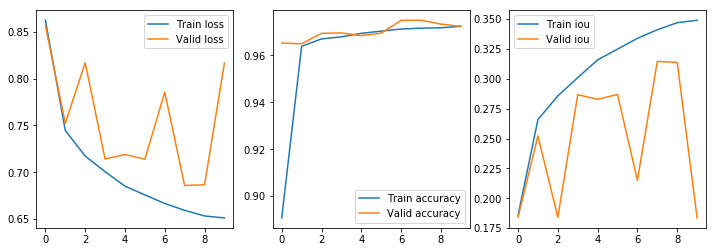

In [0]:
plt.figure(figsize=(12,4))
plt.subplot(131)
plt.plot(history.epoch, history.history["loss"], label="Train loss")
plt.plot(history.epoch, history.history["val_loss"], label="Valid loss")
plt.legend()
plt.subplot(132)
plt.plot(history.epoch, history.history["acc"], label="Train accuracy")
plt.plot(history.epoch, history.history["val_acc"], label="Valid accuracy")
plt.legend()
plt.subplot(133)
plt.plot(history.epoch, history.history["mean_iou"], label="Train iou")
plt.plot(history.epoch, history.history["val_mean_iou"], label="Valid iou")
plt.legend()
plt.show()

### Evaluating Classfication Model

In [0]:
!ls ../input/

capstone-rsna-pneumonia-detection-using-u-net
rsna-pneumonia-detection-challenge


In [0]:
model.load_weights('../input/capstone-rsna-pneumonia-detection-using-u-net/pnuemonia-detection-unet_0.6968.h5')

In [0]:
valid_gen_pred = generator_single_channel(folder, valid_filenames, pneumonia_locations,
                                            batch_size=64, image_size=224, shuffle=False, predict=True)

In [0]:
validation_preds = model.predict_generator(valid_gen_pred)

In [0]:
validation_preds_flat = np.reshape(validation_preds,newshape=(len(validation_preds),224,224))

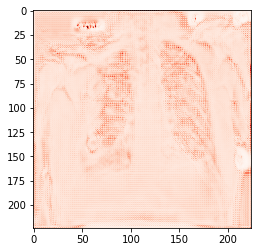

In [0]:
plt.imshow(validation_preds_flat[0],cmap='Reds')

In [0]:
cv2.imwrite('abc.png',validation_preds_flat[0])

True

In [0]:
im2 = cv2.cvtColor(cv2.imread('abc.png'),cv2.COLOR_BGR2GRAY)
ret,thresh = cv2.threshold(im2,0.9,1,cv2.THRESH_BINARY)
contours = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)

In [0]:
from skimage import measure
from skimage.transform import resize

In [0]:
folder = '../input/rsna-pneumonia-detection-challenge/stage_2_test_images'
test_filenames = os.listdir(folder)
print('n test samples:', len(test_filenames))

# create test generator with predict flag set to True
test_gen = generator_single_channel(folder, test_filenames, None, batch_size=20, image_size=224, shuffle=False, predict=True)

# create submission dictionary
submission_dict = {}
# loop through testset
for imgs, filenames in test_gen:
    # predict batch of images
    preds = model.predict(imgs)
    # loop through batch
    for pred, filename in zip(preds, filenames):
        # resize predicted mask
        pred = resize(pred, (1024, 1024), mode='reflect')
        # threshold predicted mask
        comp = pred[:, :, 0] > 0.5
        # apply connected components
        comp = measure.label(comp)
        # apply bounding boxes
        predictionString = ''
        for region in measure.regionprops(comp):
            # retrieve x, y, height and width
            y, x, y2, x2 = region.bbox
            height = y2 - y
            width = x2 - x
            # proxy for confidence score
            conf = np.mean(pred[y:y+height, x:x+width])
            # add to predictionString
            predictionString += str(conf) + ' ' + str(x) + ' ' + str(y) + ' ' + str(width) + ' ' + str(height) + ' '
        # add filename and predictionString to dictionary
        filename = filename.split('.')[0]
        submission_dict[filename] = predictionString
    # stop if we've got them all
    if len(submission_dict) >= len(test_filenames):
        break

# save dictionary as csv file
sub = pd.DataFrame.from_dict(submission_dict,orient='index')
sub.index.names = ['patientId']
sub.columns = ['PredictionString']
sub.to_csv('submission.csv')

n test samples: 3000


In [0]:
sub.head(300)

,PredictionString
patientId,
2a27aad6-fdc7-491f-885d-44d5619a6cf5,
139086b8-d4bf-4ee5-8027-cb405da2c2ab,
0de94683-fb0c-444d-be13-7617a09a3247,
bfed1172-fef5-46dc-8dcd-ba436b3ae518,0.5502842298161105 252 306 72 63 0.62188078246...
0d0a219a-f091-430b-a0c4-6a90faa1636c,0.8881838960432501 187 375 223 459 0.774220870...
1e79f233-54df-440f-98e2-ae7ec3d55766,
1d428c99-400a-42da-807e-741dafc986d6,0.8530424558308001 55 146 283 618 0.8132555304...
2c2686b4-0892-443e-a18e-fc60817a7166,
215d4b0a-b546-4eae-ab7a-39b303f7248b,0.8217916178921766 296 264 216 309
